# Tutorial

In [1]:
from prt_phasecurve import calc_spectra, phase_curve
from petitRADTRANS.poor_mans_nonequ_chem import interpol_abundances
from petitRADTRANS import Radtrans
from petitRADTRANS.nat_cst import get_PHOENIX_spec_rad
import cubedsphere as cs
import astropy.constants as const
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

## Loading the GCM data

This step highly depends on your specific GCM and the format of its output. This tutorial will showcase an example of the WASP-43b data of Schneider et al. (2021).

In [ ]:
outdir_ascii = '/Volumes/EXTERN/Simulations/exorad/paper/paper_runs/WASP-43b/run' # folder with GCM data
ds_ascii, grid = cs.open_ascii_dataset(outdir_ascii, iters=[12000/25*24*3600], prefix=["T", "U", "V", "W","Ttave"])
# converts wind and temperature
ds_ascii = cs.exorad_postprocessing(ds_ascii, outdir=outdir_ascii)

# Regrid to a lowres lon lat grid
regrid = cs.Regridder(ds_ascii, d_lon=15, d_lat=15, input_type="cs", reuse_weights=False,
                      filename=f"weights",
                      concat_mode=False, cs_grid=grid)
ds_reg_lowres = regrid()

## Creating the spectra

**Idea:**
1. Setup a Radtrans object
2. Extract longitude, latitude and temperature from the GCM data
3. Construct the abundancies (using petitRADTRANS.poor_mans_nonequ_chem in this example)
4. Calculate the spectrum (will take some time... so be patient)
5. Save the spectrum

In [ ]:
# Setup petitRADTRANS:
pRT = Radtrans(line_species=['H2O_Exomol', 'Na_allard', 'K_allard', 'CO2', 'CH4', 'NH3', 'CO_all_iso_Chubb', 'H2S', 'HCN', 'SiO', 'PH3', 'TiO_all_Exomol', 'VO', 'FeH'], \
         rayleigh_species=['H2', 'He'], \
         continuum_opacities=['H2-H2', 'H2-He', 'H-'], \
         wlen_bords_micron=[0.2, 100.], \
         do_scat_emis=True)

p_center = ds_reg_lowres.Z[::-1].values
pRT.setup_opa_structure(p_center)

In [ ]:
# Setup chemistry:
MMW = const.R.si.value / 3590 * 1000 * np.ones_like(p_center)
COs = 0.55 * np.ones_like(p_center)
FeHs = 0. * np.ones_like(p_center)

# Setup the coordinates:
mu = np.cos(ds_reg_lowres.lon * np.pi / 180.) * np.cos(ds_reg_lowres.lat * np.pi / 180.)
theta_star = np.arccos(mu) * 180 / np.pi
lon = ds_reg_lowres.lon
lat = ds_reg_lowres.lat

lon, lat = np.meshgrid(lon, lat)

# Create 1D lists from coordinates:
theta_list, lon_list, lat_list = [], [], []
for i, lon_i in enumerate(np.array(lon).flat):
    lat_i = np.array(lat).flat[i]
    theta_list.append(np.array(theta_star.sel(lon=lon_i, lat=lat_i)))
    lon_list.append(lon_i)
    lat_list.append(lat_i)

# Create 1D lists of temperature and abundancies:
abunds_list, temp_list = [], []
for i, lon_i in enumerate(np.array(lon).flat):
    temp_i_GCM = ds_reg_lowres.Ttave.sel(lon=lon_i, lat=lat_i).isel(time=-1)
    temp_i = np.array(temp_i_GCM)[::-1]

    abunds = interpol_abundances(COs, FeHs, temp_i, (p_center * u.bar).cgs.value)
    abunds["H2O_Exomol"] = abunds.pop("H2O")
    abunds["Na_allard"] = abunds.pop("Na")
    abunds["K_allard"] = abunds.pop("K")
    abunds["CO_all_iso_Chubb"] = abunds.pop("CO")
    abunds["TiO_all_Exomol"] = abunds.pop("TiO")

    temp_list.append(temp_i)
    abunds_list.append(abunds)

In [ ]:
# Calculate the spectra 
# NB: This will take a long time, depending on the resolution of your grid:    
spectra = calc_spectra(pRT, 
                       temp=temp_list, 
                       mmw=MMW, 
                       abunds=abunds_list, 
                       theta_star=theta_list, 
                       gravity = 46.9 * 100,
                       Tstar = 4520,
                       Rstar = 0.667*const.R_sun.cgs.value,
                       semimajoraxis = 0.01526 * const.au.cgs.value
    )

# Save the spectrum for future reuse!
np.save(f"emission.npy", spectra)

In [ ]:
# load spectrum
spectra = np.load(f"emission.npy")

# Extract wlen
wlen = const.c.cgs.value / pRT.freq / 1e-4

# calculate emission spectrum
flux = phase_curve([0], lon_list, lat_list, spectra)[0]

# correct flux for the ratio between solar radius and planetary radius
rpl = (1.036*u.jupiterRad).cgs.value
rstar = (0.667*u.solRad).cgs.value
flux = flux*(rpl/rstar)**2

# calculate by stellar spectrum
spec, _ = get_PHOENIX_spec_rad(4520)
stellar_intensity = np.interp(wlen*1e-4, spec[:,0], spec[:,1])

# Norm flux to stellar intensity
flux = flux/stellar_intensity

In [ ]:
plt.plot(wlen, flux*1e6)
plt.xscale('log')
plt.yscale('linear')
plt.xlim([0.2,15])
plt.ylim([0.2,1e4])
plt.ylabel(r'$F_\mathrm{pl}/F_\mathrm{star}$ [ppm]')
plt.xlabel('$\lambda$ [$\mu$m]')
plt.title('Dayside emission spectrum')
plt.show()

In [ ]:
phases = np.linspace(0,1,40)

# load spectrum
spectra = np.load(f"emission.npy")

# Extract wlen
wlen = const.c.cgs.value / pRT.freq / 1e-4

# calculate emission spectrum
flux = phase_curve(phases, lon_list, lat_list, spectra)[0]

# correct flux for the ratio between solar radius and planetary radius
rpl = (1.036*u.jupiterRad).cgs.value
rstar = (0.667*u.solRad).cgs.value
flux = flux*(rpl/rstar)**2

# calculate by stellar spectrum
spec, _ = get_PHOENIX_spec_rad(4520)
stellar_intensity = np.interp(wlen*1e-4, spec[:,0], spec[:,1])

# Norm flux to stellar intensity
flux = flux/stellar_intensity

<IPython.core.display.Javascript object>


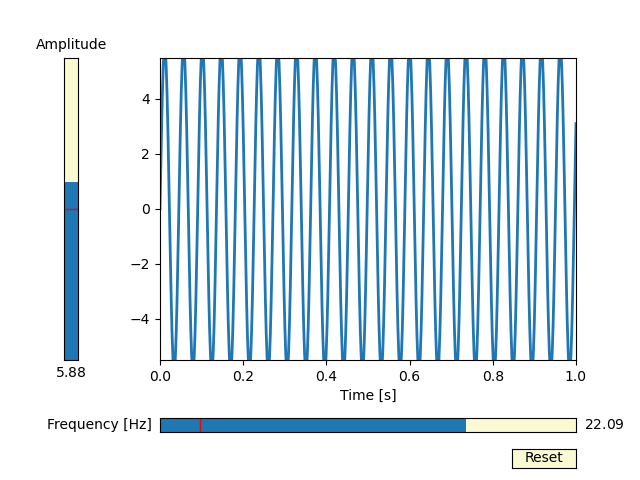

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button


# The parametrized function to be plotted
def f(t, amplitude, frequency):
    return amplitude * np.sin(2 * np.pi * frequency * t)

t = np.linspace(0, 1, 1000)

# Define initial parameters
init_amplitude = 5
init_frequency = 3

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots()
line, = plt.plot(t, f(t, init_amplitude, init_frequency), lw=2)
ax.set_xlabel('Time [s]')

axcolor = 'lightgoldenrodyellow'
ax.margins(x=0)

# adjust the main plot to make room for the sliders
plt.subplots_adjust(left=0.25, bottom=0.25)

# Make a horizontal slider to control the frequency.
axfreq = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
freq_slider = Slider(
    ax=axfreq,
    label='Frequency [Hz]',
    valmin=0.1,
    valmax=30,
    valinit=init_frequency,
)

# Make a vertically oriented slider to control the amplitude
axamp = plt.axes([0.1, 0.25, 0.0225, 0.63], facecolor=axcolor)
amp_slider = Slider(
    ax=axamp,
    label="Amplitude",
    valmin=0,
    valmax=10,
    valinit=init_amplitude,
    orientation="vertical"
)


# The function to be called anytime a slider's value changes
def update(val):
    line.set_ydata(f(t, amp_slider.val, freq_slider.val))
    fig.canvas.draw_idle()


# register the update function with each slider
freq_slider.on_changed(update)
amp_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')


def reset(event):
    freq_slider.reset()
    amp_slider.reset()
button.on_clicked(reset)

plt.show()